## Data Preview

In [1]:
from lib.data_manager import DataManager

data_manager = DataManager(['ebola-essien'])
users_df = data_manager.get_users_df()
tweets_df = data_manager.get_tweets_df()

In [2]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   thread_id                 216 non-null    int64              
 1   tweet_id                  216 non-null    int64              
 2   user_id                   216 non-null    int64              
 3   event                     216 non-null    object             
 4   is_rumour                 216 non-null    bool               
 5   tweet_class               216 non-null    object             
 6   in_reply_to_status_id     216 non-null    int64              
 7   in_reply_to_user_id       216 non-null    int64              
 8   support                   2 non-null      object             
 9   responsetype_vs_source    32 non-null     object             
 10  responsetype_vs_previous  10 non-null     object             
 11  favorite_count     

In [3]:
tweets_df.head()

,thread_id,tweet_id,user_id,event,is_rumour,tweet_class,in_reply_to_status_id,in_reply_to_user_id,support,responsetype_vs_source,responsetype_vs_previous,favorite_count,retweet_count,created_at,unix_ts,normalized_ts,relative_ts_rumour,relative_ts_event,place
0,521346721226711040,521346721226711040,579635019,ebola-essien,True,source,0,0,supporting,NaN,NaN,85,575,2014-10-12 17:08:39+00:00,1.413134e+09,2014-10-12 13:08:39-04:00,0.0,0.0,NaN
1,521346721226711040,521349366037356544,463260500,ebola-essien,True,direct reply,521346721226711040,579635019,NaN,appeal-for-more-information,NaN,5,1,2014-10-12 17:19:09+00:00,1.413134e+09,2014-10-12 13:19:09-04:00,630.0,630.0,NaN
2,521346721226711040,521349434719076352,430026970,ebola-essien,True,direct reply,521346721226711040,579635019,NaN,comment,NaN,1,1,2014-10-12 17:19:26+00:00,1.413134e+09,2014-10-12 13:19:26-04:00,647.0,647.0,NaN
3,521346721226711040,521350130851921921,379856833,ebola-essien,True,direct reply,521346721226711040,579635019,NaN,comment,NaN,0,0,2014-10-12 17:22:12+00:00,1.413135e+09,2014-10-12 13:22:12-04:00,813.0,813.0,"{'full_name': 'Brasília, Distrito Federal', 'u..."
4,521346721226711040,521350466647891968,458672503,ebola-essien,True,direct reply,521346721226711040,579635019,NaN,comment,NaN,1,0,2014-10-12 17:23:32+00:00,1.413135e+09,2014-10-12 13:23:32-04:00,893.0,893.0,NaN


In [4]:
import networkx as nx
import pandas as pd
from lib.enums import EdgeRelationship

def create_user_graph(users_df: pd.DataFrame, tweets_df: pd.DataFrame, relation: EdgeRelationship) -> nx.Graph:
    user_graph = nx.Graph()

    for _, user in users_df.iterrows():
        user_id = user.user_id
        user_graph.add_node(user_id)

    if relation == EdgeRelationship.FOLLOW:
        for _, user in users_df.iterrows():
            for following_user_id in user['following']:
                user_graph.add_edge(user['user_id'], following_user_id, relation=EdgeRelationship.FOLLOW)
            for follower_user_id in user['followers']:
                user_graph.add_edge(follower_user_id, user['user_id'], relation=EdgeRelationship.FOLLOW)

    if relation == EdgeRelationship.REPLY:
        for _, tweet in tweets_df.iterrows():
            if tweet['in_reply_to_user_id']:
                user_graph.add_edge(tweet['user_id'], tweet['in_reply_to_user_id'], relation=EdgeRelationship.REPLY)
    
    if relation == EdgeRelationship.RETWEET:
        for _, tweet in tweets_df.iterrows():
            if tweet.tweet_class == 'retweet':
                user_graph.add_edge(tweet['user_id'], tweet['thread_id'], relation=EdgeRelationship.RETWEET)
    
    return user_graph

In [5]:
user_graph = create_user_graph(users_df, tweets_df, relation=EdgeRelationship.FOLLOW)

In [6]:
self_loops = list(nx.selfloop_edges(user_graph))
if self_loops:
    print("Nodes with self-loops:")
    for u, v in self_loops:
        print(f"Node {u} has a self-loop")

Nodes with self-loops:
Node 579635019 has a self-loop
Node 379856833 has a self-loop
Node 471014242 has a self-loop
Node 466457803 has a self-loop
Node 70671249 has a self-loop
Node 194622639 has a self-loop
Node 2370781272 has a self-loop
Node 1381490449 has a self-loop
Node 87786129 has a self-loop
Node 148334455 has a self-loop
Node 1594903015 has a self-loop
Node 861997543 has a self-loop
Node 518034679 has a self-loop
Node 149021247 has a self-loop
Node 1161707989 has a self-loop


In [13]:
tweets_df[tweets_df['user_id'] == 1594903015]

,thread_id,tweet_id,user_id,event,is_rumour,tweet_class,in_reply_to_status_id,in_reply_to_user_id,support,responsetype_vs_source,responsetype_vs_previous,favorite_count,retweet_count,created_at,unix_ts,normalized_ts,relative_ts_rumour,relative_ts_event,place
207,521360486387175424,521360486387175424,1594903015,ebola-essien,True,source,0,0,supporting,NaN,NaN,328,781,2014-10-12 18:03:21+00:00,1.413137e+09,2014-10-12 14:03:21-04:00,3282.0,3282.0,NaN
213,521360486387175424,521378427681898498,1594903015,ebola-essien,True,direct reply,521360486387175424,1594903015,NaN,disagreed,NaN,47,65,2014-10-12 19:14:38+00:00,1.413141e+09,2014-10-12 15:14:38-04:00,7559.0,7559.0,NaN


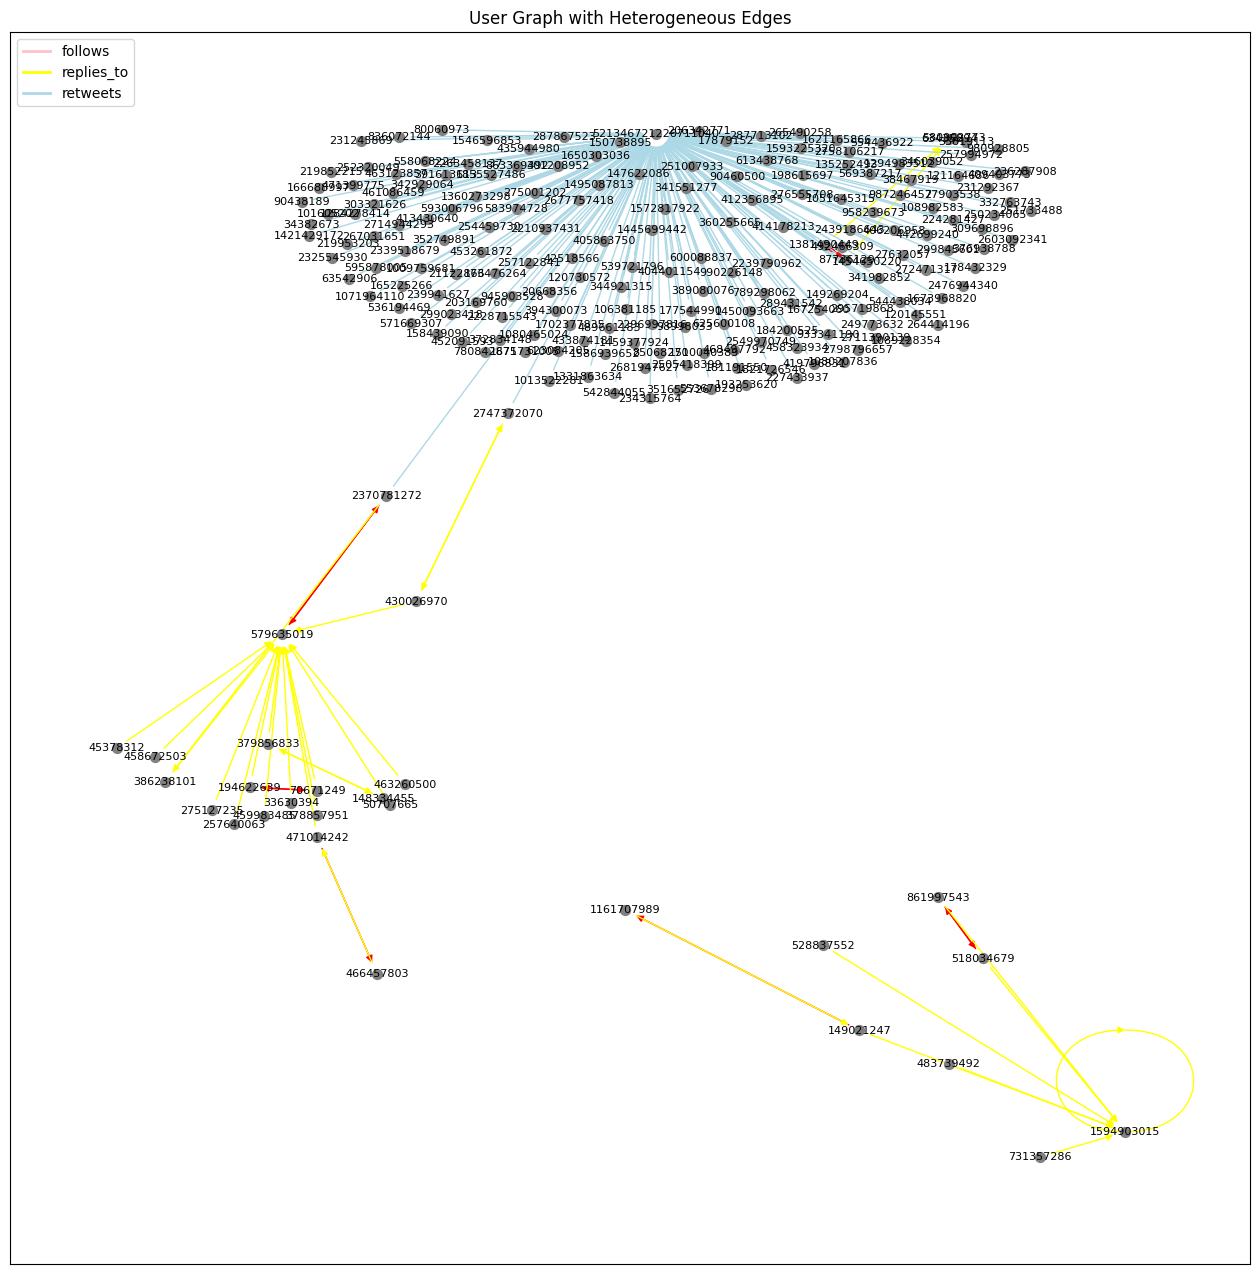

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# A higher 'k' value means more space between nodes (try values from 0.2 to 1.0)
pos = nx.spring_layout(user_graph, k=0.2)
plt.figure(figsize=(16, 16))

# Draw nodes
nx.draw_networkx_nodes(user_graph, pos, node_size=50, node_color='grey')

# Draw edges with different colors based on the relationship type
edges_follows = [(u, v) for u, v, d in user_graph.edges(data=True) if d['relation'] == 'follows']
edges_replies_to = [(u, v) for u, v, d in user_graph.edges(data=True) if d['relation'] == 'replies_to']
edges_retweets = [(u, v) for u, v, d in user_graph.edges(data=True) if d['relation'] == 'retweets']

# Draw edges with specific colors
nx.draw_networkx_edges(user_graph, pos, edgelist=edges_follows, edge_color='red', label='follows')
nx.draw_networkx_edges(user_graph, pos, edgelist=edges_replies_to, edge_color='yellow', label='replies_to')
nx.draw_networkx_edges(user_graph, pos, edgelist=edges_retweets, edge_color='lightblue', label='retweets')

# Draw labels
nx.draw_networkx_labels(user_graph, pos, font_size=8)

# Custom legend for edges
legend_elements = [
    Line2D([0], [0], color='pink', lw=2, label='follows'),
    Line2D([0], [0], color='yellow', lw=2, label='replies_to'),
    Line2D([0], [0], color='lightblue', lw=2, label='retweets')
]

# Add the custom legend to the plot
plt.legend(handles=legend_elements, loc='upper left')

# Title and display the plot
plt.title("User Graph with Heterogeneous Edges")
plt.show()

# Community Detection

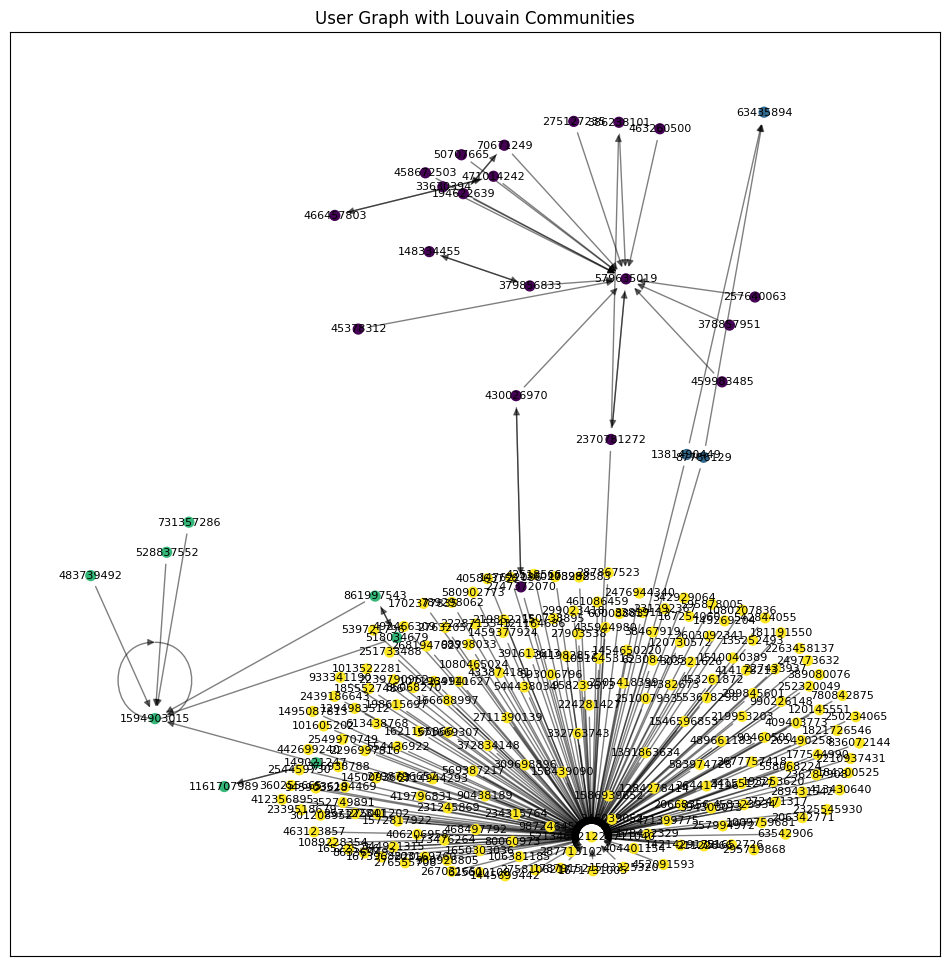

In [18]:
from networkx.algorithms.community import louvain_communities, girvan_newman

communities = louvain_communities(user_graph)

# Create a mapping from node to community
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Draw the graph with communities
pos = nx.spring_layout(user_graph, k=0.3)   # layout for nodes
cmap = plt.get_cmap('viridis')              # color map for the communities

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(user_graph, pos, node_size=50,
                       node_color=[community_map[node] for node in user_graph.nodes()], cmap=cmap)
nx.draw_networkx_edges(user_graph, pos, alpha=0.5)
nx.draw_networkx_labels(user_graph, pos, font_size=8)

plt.title("User Graph with Louvain Communities")
plt.show()

In [19]:
print(f"Number of communities: {len(communities)}")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

Number of communities: 4
Community 1: {379856833, 275127235, 45378312, 579635019, 466457803, 148334455, 50707665, 70671249, 463260500, 386238101, 2370781272, 430026970, 378857951, 471014242, 2747372070, 194622639, 458672503, 33630394, 459983485, 257640063}
Community 2: {1381490449, 87786129, 63435894}
Community 3: {483739492, 731357286, 861997543, 1594903015, 528837552, 1161707989, 518034679, 149021247}
Community 4: {521346721226711040, 558068224, 404401154, 1572817922, 933341190, 389080076, 135252493, 435944980, 2228715543, 257122841, 303321626, 42518566, 167254060, 90438189, 80060973, 231245869, 453261872, 27903538, 219953203, 299023418, 1650303036, 1855527486, 249773632, 1089228354, 539721796, 1331863634, 2210937431, 1450093663, 332763743, 267031651, 1593225320, 2758106217, 625600108, 17879152, 206342771, 595878005, 63542906, 1080465024, 287867523, 341982852, 492466309, 1284278414, 120145551, 198615697, 542844055, 2505418399, 342929064, 394300073, 391613613, 623084205, 341551277, 36

Number of cliques: 205
Largest clique size: 3


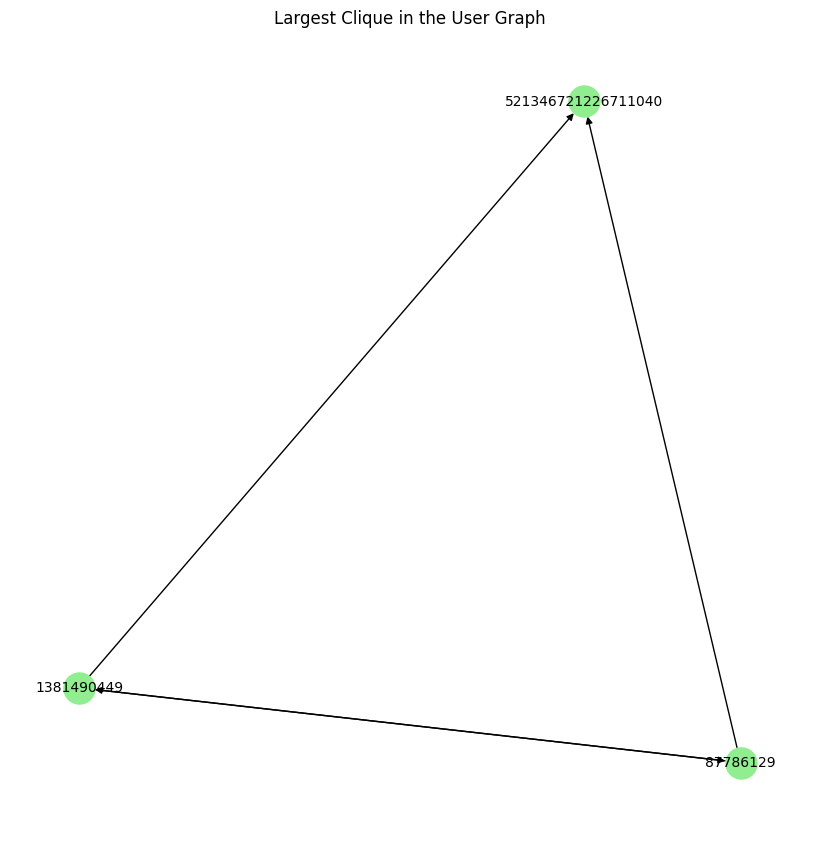

In [24]:
from networkx.algorithms.clique import find_cliques

cliques = list(find_cliques(user_graph.to_undirected()))
clique_sizes = [len(clique) for clique in cliques]

# Find the largest cliques
largest_cliques = [clique for clique in cliques if len(clique) == max(clique_sizes)]
print(f"Number of cliques: {len(cliques)}")
print(f"Largest clique size: {max(clique_sizes)}")

# Visualize the largest clique
largest_clique = largest_cliques[0]  # First largest clique
plt.figure(figsize=(8, 8))
nx.draw(user_graph.subgraph(largest_clique), with_labels=True, node_size=500, node_color='lightgreen', font_size=10)
plt.title("Largest Clique in the User Graph")
plt.show()

In [ ]:
# print(f"Number of cliques: {len(cliques)}")
# for i, clique in enumerate(cliques):
#     print(f"Clique {i + 1}: {clique}")

In [25]:
# Calculate assortativity coefficient for the given attribute
attribute = "favorite_count"
assortativity = nx.attribute_assortativity_coefficient(user_graph, attribute)
print(f"Assortativity coefficient for {attribute}: {assortativity}")


Assortativity coefficient for favorite_count: nan


/mnt/c/Users/tranh/Desktop/unistuff/MSc/2ia/SNA/RumourDetection/.venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


Nodes acting as bridges: []


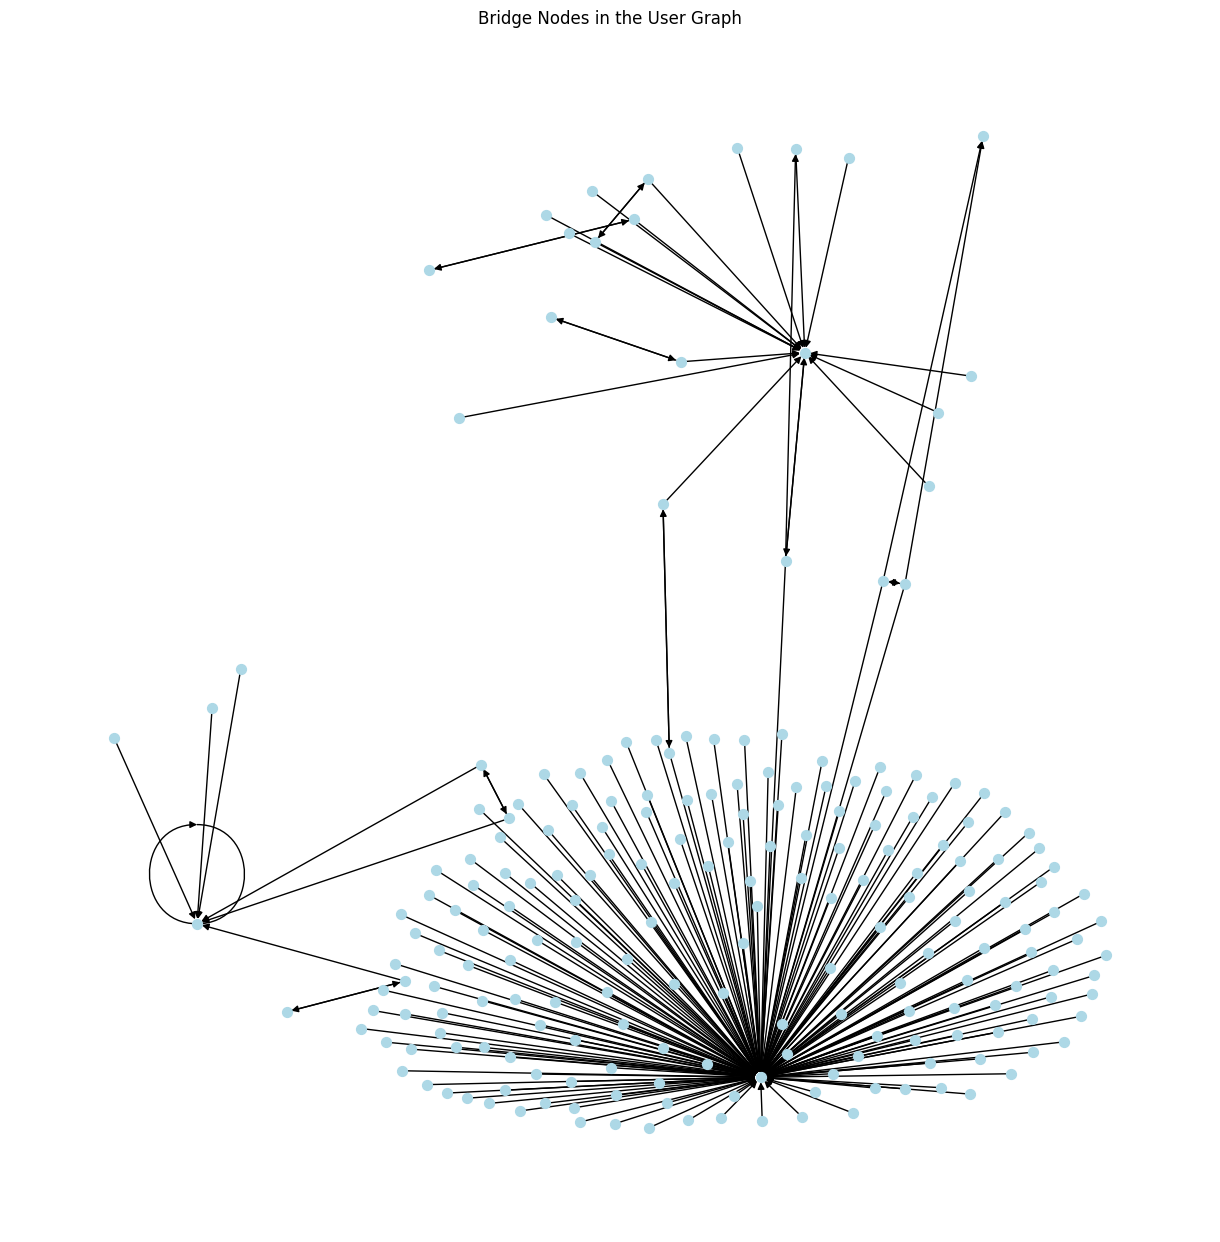

In [26]:
from networkx.algorithms.centrality import betweenness_centrality

# Calculate betweenness centrality for all nodes
betweenness = betweenness_centrality(user_graph)

# Identify nodes that serve as bridges (i.e., nodes with high betweenness)
bridge_threshold = 0.01
bridge_nodes = [node for node, centrality in betweenness.items() if centrality > bridge_threshold]

print(f"Nodes acting as bridges: {bridge_nodes}")

# Visualize bridge nodes in the graph
plt.figure(figsize=(12, 12))
nx.draw(user_graph, pos, node_size=50, node_color='lightblue')
nx.draw_networkx_nodes(user_graph, pos, nodelist=bridge_nodes, node_size=100, node_color='red')  # Highlight bridge nodes
plt.title("Bridge Nodes in the User Graph")
plt.show()


# Homophily Analysis

# Bridge Nodes and Influence